# &#x1F4D1; &nbsp;  The Data Set of Flower Images

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron');
body {background-color: gainsboro;} 
a {color: #818286; font-family: Orbitron;} 
h1, h2 {color: #37c9e1; font-family: Orbitron; text-shadow: 4px 4px 4px #ccc;} 
h3, h4 {color: #818286; font-family: Orbitron; text-shadow: 4px 4px 4px #ccc;}
span {text-shadow: 4px 4px 4px #ccc;}        
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategray;}        
</style>

## &#x1F310; &nbsp; 0. Code Library and Links

In [16]:
import numpy as np 
import pandas as pd 

import cv2
import os
import scipy
import h5py
from six.moves import cPickle as pickle
from skimage import io

from PIL import ImageFile
from tqdm import tqdm

In [3]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [4]:
from keras.preprocessing import image as keras_image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [6]:
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  

def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy'); 
    
def path_to_tensor(img_path):
    img = keras_image.load_img("/Users/olgabelitskaya/cookbooks/flower_images/"+img_path, 
                               target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                     

## &#x1F310; &nbsp; 1. Explore the Data

In [7]:
flowers = pd.read_csv("/Users/olgabelitskaya/cookbooks/flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].as_matrix()
flower_tensors = paths_to_tensor(flower_files);

100%|██████████| 210/210 [00:05<00:00, 40.85it/s]


In [12]:
flower_tensors.shape

(210, 128, 128, 3)

In [13]:
flower_targets.shape

(210,)

In [15]:
with h5py.File('FlowerColorImages.h5', 'w') as f:
    f.create_dataset('images', data = flower_tensors)
    f.create_dataset('labels', data = flower_targets)

In [17]:
pickle_file = 'FlowerColorImages.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'images': flower_tensors, 'labels': flower_targets}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 41289619


Label:  9


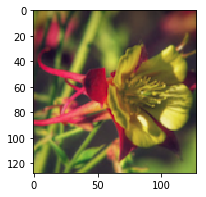

In [8]:
print('Label: ', flower_targets[168])
flower_image = cv2.imread('/Users/olgabelitskaya/cookbooks/flower_images/'+flower_files[168])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(rgb_flower_image);

In [9]:
x_train, x_test, y_train, y_test = train_test_split(flower_tensors, flower_targets, 
                                                    test_size = 0.1, random_state = 1)
[x_train.shape, y_train.shape, x_test.shape, y_test.shape]

[(189, 128, 128, 3), (189,), (21, 128, 128, 3), (21,)]

Label:  3


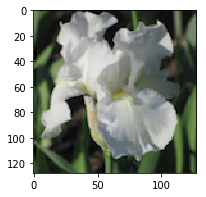

In [10]:
print('Label: ', y_train[1])
plt.figure(figsize=(3,3))
plt.imshow((x_train[1]/255).reshape(128,128,3));

In [11]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

c_y_train = to_categorical(y_train, 10)
c_y_test = to_categorical(y_test, 10)

[x_train.shape, c_y_train.shape, x_test.shape, c_y_test.shape]

[(189, 128, 128, 3), (189, 10), (21, 128, 128, 3), (21, 10)]

## &#x1F310; &nbsp; 2. Models

In [12]:
# MLP
def mlp_mc_model():
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_shape=(128*128*3,)))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.2))    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()

In [17]:
mlp_mc_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_mc.flowers.hdf5', 
                                      verbose=2, save_best_only=True)
mlp_mc_history = mlp_mc_model.fit(x_train.reshape(-1, 128*128*3), c_y_train,
                                  validation_data=(x_test.reshape(-1, 128*128*3), c_y_test),
                                  epochs=100, batch_size=64, verbose=2, 
                                  callbacks=[mlp_mc_checkpointer])

Train on 189 samples, validate on 21 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 5.54383, saving model to weights.best.mlp_mc.flowers.hdf5
15s - loss: 2.3451 - acc: 0.1323 - val_loss: 5.5438 - val_acc: 0.0000e+00
Epoch 2/100
Epoch 00001: val_loss did not improve
1s - loss: 1.5972 - acc: 0.4603 - val_loss: 7.0945 - val_acc: 0.1429
Epoch 3/100
Epoch 00002: val_loss did not improve
1s - loss: 1.0263 - acc: 0.6931 - val_loss: 5.7409 - val_acc: 0.1429
Epoch 4/100
Epoch 00003: val_loss did not improve
1s - loss: 0.6840 - acc: 0.8042 - val_loss: 5.9100 - val_acc: 0.3333
Epoch 5/100
Epoch 00004: val_loss did not improve
1s - loss: 0.4339 - acc: 0.8942 - val_loss: 7.2566 - val_acc: 0.2381
Epoch 6/100
Epoch 00005: val_loss did not improve
1s - loss: 0.2904 - acc: 0.9418 - val_loss: 7.6030 - val_acc: 0.2381
Epoch 7/100
Epoch 00006: val_loss did not improve
1s - loss: 0.1673 - acc: 0.9683 - val_loss: 7.6427 - val_acc: 0.2381
Epoch 8/100
Epoch 00007: val_loss did not improve
1s -

Epoch 00049: val_loss improved from 2.83717 to 2.78114, saving model to weights.best.mlp_mc.flowers.hdf5
3s - loss: 2.8323e-04 - acc: 1.0000 - val_loss: 2.7811 - val_acc: 0.3810
Epoch 51/100
Epoch 00050: val_loss improved from 2.78114 to 2.73044, saving model to weights.best.mlp_mc.flowers.hdf5
3s - loss: 3.1659e-04 - acc: 1.0000 - val_loss: 2.7304 - val_acc: 0.4286
Epoch 52/100
Epoch 00051: val_loss improved from 2.73044 to 2.68103, saving model to weights.best.mlp_mc.flowers.hdf5
3s - loss: 1.6653e-04 - acc: 1.0000 - val_loss: 2.6810 - val_acc: 0.4286
Epoch 53/100
Epoch 00052: val_loss improved from 2.68103 to 2.63469, saving model to weights.best.mlp_mc.flowers.hdf5
6s - loss: 2.6929e-04 - acc: 1.0000 - val_loss: 2.6347 - val_acc: 0.4286
Epoch 54/100
Epoch 00053: val_loss improved from 2.63469 to 2.59013, saving model to weights.best.mlp_mc.flowers.hdf5
6s - loss: 2.2599e-04 - acc: 1.0000 - val_loss: 2.5901 - val_acc: 0.4286
Epoch 55/100
Epoch 00054: val_loss improved from 2.59013 t

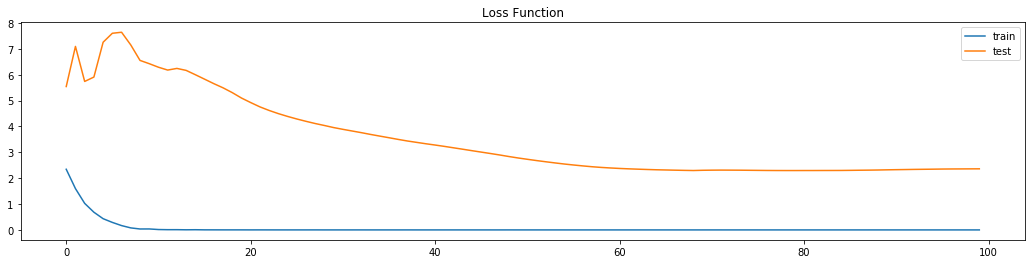

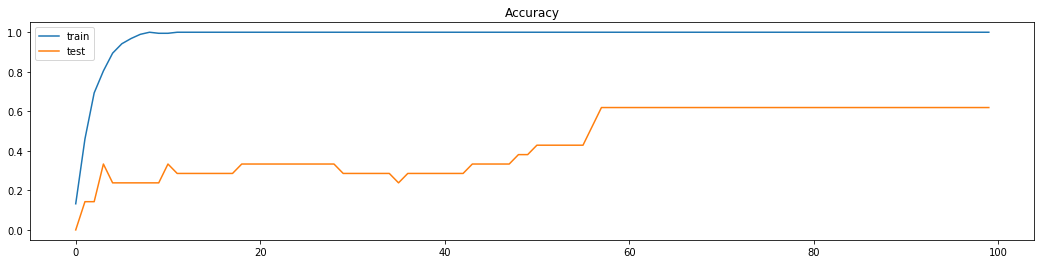

In [20]:
loss_plot(mlp_mc_history)
acc_plot(mlp_mc_history)

In [21]:
mlp_mc_model.load_weights('weights.best.mlp_mc.flowers.hdf5')
mlp_mc_test_score = mlp_mc_model.evaluate(x_test.reshape(-1, 128*128*3), c_y_test)
mlp_mc_test_score

21/21 [==============================] - 0s


[2.2955043315887451, 0.61904764175415039]

In [64]:
# CNN
def cnn_mc_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

In [65]:
cnn_mc_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_mc.flowers.hdf5', 
                                      verbose=2, save_best_only=True)
cnn_mc_history = cnn_mc_model.fit(x_train, c_y_train, 
                                  epochs=150, batch_size=64, verbose=2,
                                  validation_data=(x_test, c_y_test),
                                  callbacks=[cnn_mc_checkpointer])

Train on 189 samples, validate on 21 samples
Epoch 1/150
Epoch 00000: val_loss improved from inf to 2.28265, saving model to weights.best.cnn_mc.flowers.hdf5
51s - loss: 2.3560 - acc: 0.0794 - val_loss: 2.2827 - val_acc: 0.0952
Epoch 2/150
Epoch 00001: val_loss did not improve
37s - loss: 2.2164 - acc: 0.1587 - val_loss: 2.3590 - val_acc: 0.1429
Epoch 3/150
Epoch 00002: val_loss improved from 2.28265 to 2.16029, saving model to weights.best.cnn_mc.flowers.hdf5
35s - loss: 2.2077 - acc: 0.1958 - val_loss: 2.1603 - val_acc: 0.0952
Epoch 4/150
Epoch 00003: val_loss improved from 2.16029 to 2.04503, saving model to weights.best.cnn_mc.flowers.hdf5
35s - loss: 1.9939 - acc: 0.2751 - val_loss: 2.0450 - val_acc: 0.2381
Epoch 5/150
Epoch 00004: val_loss improved from 2.04503 to 1.92449, saving model to weights.best.cnn_mc.flowers.hdf5
33s - loss: 2.0090 - acc: 0.2540 - val_loss: 1.9245 - val_acc: 0.0952
Epoch 6/150
Epoch 00005: val_loss did not improve
31s - loss: 1.9050 - acc: 0.3069 - val_lo

Epoch 00060: val_loss did not improve
54s - loss: 1.1548 - acc: 0.6349 - val_loss: 1.8629 - val_acc: 0.4286
Epoch 62/150
Epoch 00061: val_loss did not improve
48s - loss: 0.9963 - acc: 0.6296 - val_loss: 0.8987 - val_acc: 0.6667
Epoch 63/150
Epoch 00062: val_loss improved from 0.89205 to 0.83655, saving model to weights.best.cnn_mc.flowers.hdf5
131s - loss: 0.7181 - acc: 0.7989 - val_loss: 0.8365 - val_acc: 0.7143
Epoch 64/150
Epoch 00063: val_loss did not improve
61s - loss: 0.6387 - acc: 0.8042 - val_loss: 1.0311 - val_acc: 0.5714
Epoch 65/150
Epoch 00064: val_loss improved from 0.83655 to 0.82126, saving model to weights.best.cnn_mc.flowers.hdf5
52s - loss: 0.7293 - acc: 0.7566 - val_loss: 0.8213 - val_acc: 0.7143
Epoch 66/150
Epoch 00065: val_loss did not improve
72s - loss: 0.6292 - acc: 0.7619 - val_loss: 0.8537 - val_acc: 0.7619
Epoch 67/150
Epoch 00066: val_loss improved from 0.82126 to 0.76614, saving model to weights.best.cnn_mc.flowers.hdf5
77s - loss: 0.5972 - acc: 0.8148 -

Epoch 00125: val_loss did not improve
86s - loss: 1.5555 - acc: 0.5344 - val_loss: 0.7828 - val_acc: 0.8095
Epoch 127/150
Epoch 00126: val_loss did not improve
47s - loss: 0.5034 - acc: 0.8042 - val_loss: 0.8351 - val_acc: 0.7619
Epoch 128/150
Epoch 00127: val_loss did not improve
80s - loss: 0.4523 - acc: 0.8466 - val_loss: 0.8529 - val_acc: 0.7619
Epoch 129/150
Epoch 00128: val_loss did not improve
107s - loss: 0.4265 - acc: 0.8889 - val_loss: 0.7162 - val_acc: 0.7619
Epoch 130/150
Epoch 00129: val_loss did not improve
141s - loss: 0.4470 - acc: 0.8148 - val_loss: 0.9471 - val_acc: 0.7619
Epoch 131/150
Epoch 00130: val_loss did not improve
62s - loss: 0.5500 - acc: 0.7937 - val_loss: 0.7628 - val_acc: 0.7143
Epoch 132/150
Epoch 00131: val_loss did not improve
41s - loss: 0.4288 - acc: 0.8624 - val_loss: 0.6583 - val_acc: 0.8095
Epoch 133/150
Epoch 00132: val_loss did not improve
42s - loss: 0.3986 - acc: 0.8677 - val_loss: 0.8298 - val_acc: 0.7619
Epoch 134/150
Epoch 00133: val_loss 

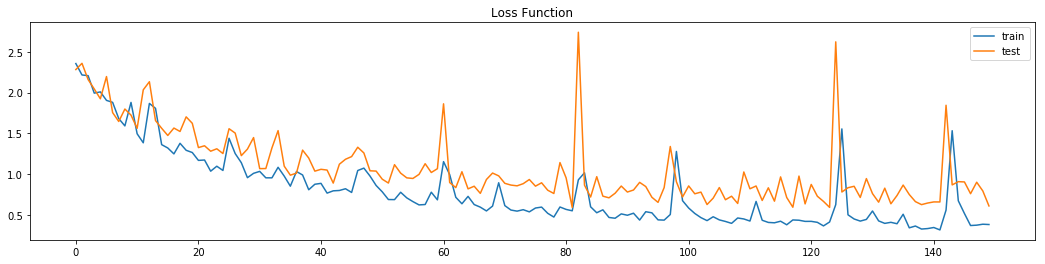

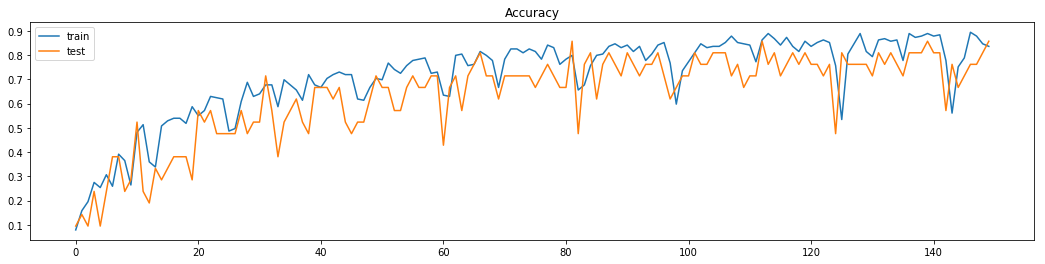

In [66]:
loss_plot(cnn_mc_history)
acc_plot(cnn_mc_history)

In [67]:
cnn_mc_model.load_weights('weights.best.cnn_mc.flowers.hdf5')
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
cnn_mc_test_score

21/21 [==============================] - 1s


[0.59297561645507812, 0.8571428656578064]

In [ ]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)
cnn_mc_dg_history = cnn_mc_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                               steps_per_epoch = 189, epochs = 5, verbose=2, 
                                               validation_data = (x_test, c_y_test),
                                               callbacks=[cnn_mc_checkpointer])

Epoch 1/5
Epoch 00000: val_loss did not improve
1190s - loss: 0.1500 - acc: 0.9513 - val_loss: 1.0536 - val_acc: 0.8095
Epoch 2/5
Epoch 00001: val_loss did not improve
1168s - loss: 0.0864 - acc: 0.9706 - val_loss: 1.4193 - val_acc: 0.8095
Epoch 3/5
Epoch 00002: val_loss did not improve
1046s - loss: 0.0912 - acc: 0.9708 - val_loss: 1.1578 - val_acc: 0.8095
Epoch 4/5
Epoch 00003: val_loss did not improve
1196s - loss: 0.0781 - acc: 0.9763 - val_loss: 1.4713 - val_acc: 0.7619
Epoch 5/5


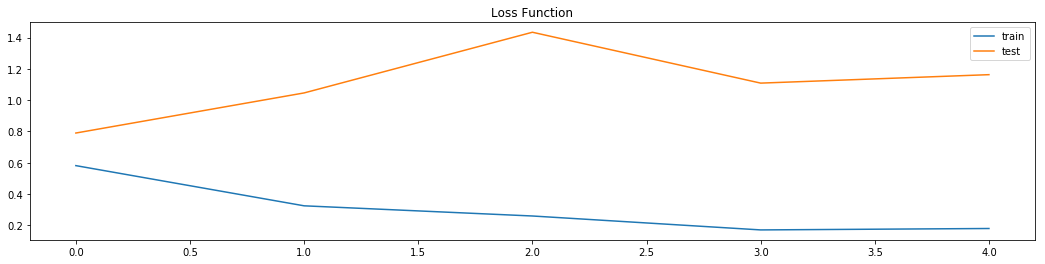

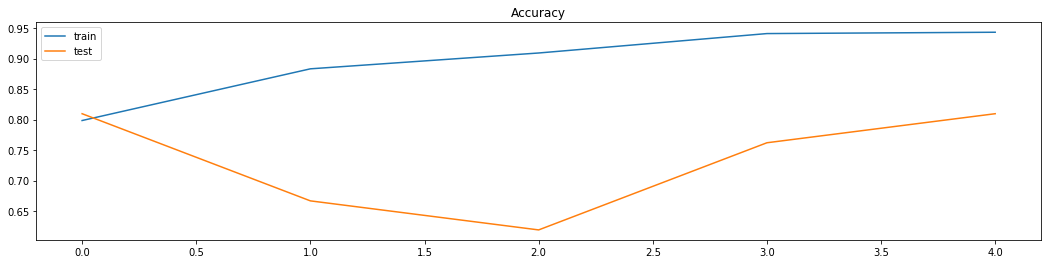

In [50]:
loss_plot(cnn_mc_dg_history)
acc_plot(cnn_mc_dg_history)

In [51]:
cnn_mc_model.load_weights('weights.best.cnn_mc.flowers.hdf5')
cnn_mc_dg_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
cnn_mc_dg_test_score

21/21 [==============================] - 0s


[0.78972536325454712, 0.8095238208770752]

In [25]:
# RNN
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(128, return_sequences=True, input_shape=(1, 128*128*3))) 
#    model.add(LSTM(128, return_sequences=True))
    
    model.add(LSTM(128))  
    model.add(Dense(512, activation='tanh'))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

rnn_mc_model = rnn_mc_model()

In [26]:
rnn_mc_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_mc.flowers.hdf5', 
                                      verbose=2, save_best_only=True)
rnn_mc_history = rnn_mc_model.fit(x_train.reshape(-1,1,128*128*3), c_y_train, 
                                  epochs=30, batch_size=64, verbose=2,
                                  validation_data=(x_test.reshape(-1,1,128*128*3), c_y_test),
                                  callbacks=[rnn_mc_checkpointer])

Train on 189 samples, validate on 21 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 2.28176, saving model to weights.best.rnn_mc.flowers.hdf5
34s - loss: 2.3099 - acc: 0.0794 - val_loss: 2.2818 - val_acc: 0.1905
Epoch 2/30
Epoch 00001: val_loss improved from 2.28176 to 2.25892, saving model to weights.best.rnn_mc.flowers.hdf5
16s - loss: 2.2710 - acc: 0.1640 - val_loss: 2.2589 - val_acc: 0.0952
Epoch 3/30
Epoch 00002: val_loss improved from 2.25892 to 2.21680, saving model to weights.best.rnn_mc.flowers.hdf5
14s - loss: 2.2286 - acc: 0.1746 - val_loss: 2.2168 - val_acc: 0.0952
Epoch 4/30
Epoch 00003: val_loss improved from 2.21680 to 2.17493, saving model to weights.best.rnn_mc.flowers.hdf5
17s - loss: 2.1892 - acc: 0.2328 - val_loss: 2.1749 - val_acc: 0.2381
Epoch 5/30
Epoch 00004: val_loss improved from 2.17493 to 2.11627, saving model to weights.best.rnn_mc.flowers.hdf5
20s - loss: 2.1169 - acc: 0.2910 - val_loss: 2.1163 - val_acc: 0.2381
Epoch 6/30
Epoch 00005: val_l

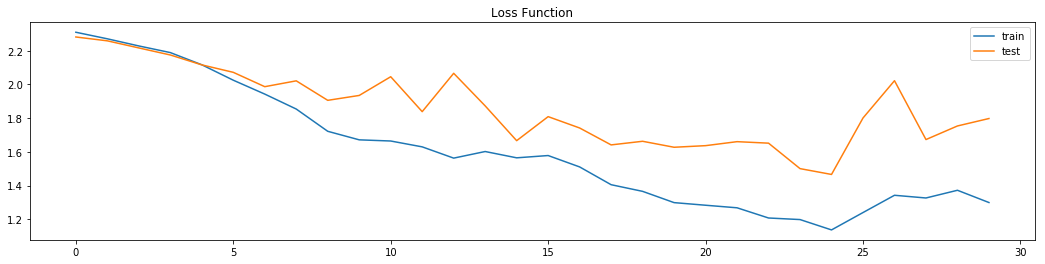

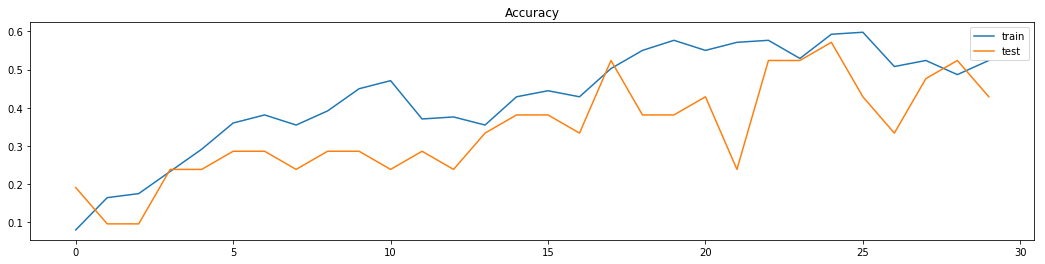

In [27]:
loss_plot(rnn_mc_history)
acc_plot(rnn_mc_history)

In [28]:
rnn_mc_model.load_weights('weights.best.rnn_mc.flowers.hdf5')
rnn_mc_test_score = rnn_mc_model.evaluate(x_test.reshape(-1,1,128*128*3), c_y_test)
rnn_mc_test_score

21/21 [==============================] - 0s


[1.4658287763595581, 0.57142859697341919]

## &#x1F310; &nbsp; 3. Applications

In [79]:
# InceptionV3
iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x = iv3_base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

y = Dense(10, activation='softmax')(x)

iv3_model = Model(inputs=iv3_base_model.input, outputs=y)

In [80]:
# Freeze InceptionV3 convolutional layers
for layer in iv3_base_model.layers:
    layer.trainable = False
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
steps, epochs = 150, 10
data_generator = keras_image.ImageDataGenerator(shear_range=0.2, 
                                                zoom_range=0.2, 
                                                horizontal_flip=True)

In [82]:
iv3_history = iv3_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                      steps_per_epoch = steps, epochs = epochs, verbose=2, 
                                      validation_data = (x_test, c_y_test))

Epoch 1/10
740s - loss: 0.6370 - acc: 0.8119 - val_loss: 1.9297 - val_acc: 0.5238
Epoch 2/10
710s - loss: 0.2400 - acc: 0.9288 - val_loss: 1.0962 - val_acc: 0.7143
Epoch 3/10
721s - loss: 0.1535 - acc: 0.9546 - val_loss: 1.2874 - val_acc: 0.7619
Epoch 4/10
708s - loss: 0.1357 - acc: 0.9580 - val_loss: 1.4780 - val_acc: 0.6667
Epoch 5/10
725s - loss: 0.1342 - acc: 0.9570 - val_loss: 1.4410 - val_acc: 0.6190
Epoch 6/10
785s - loss: 0.1110 - acc: 0.9652 - val_loss: 1.2136 - val_acc: 0.7619
Epoch 7/10
812s - loss: 0.1027 - acc: 0.9699 - val_loss: 1.0086 - val_acc: 0.7143
Epoch 8/10
758s - loss: 0.0859 - acc: 0.9724 - val_loss: 1.1999 - val_acc: 0.6667
Epoch 9/10
711s - loss: 0.0859 - acc: 0.9730 - val_loss: 1.2304 - val_acc: 0.6667
Epoch 10/10
698s - loss: 0.0830 - acc: 0.9752 - val_loss: 0.8310 - val_acc: 0.6190


In [83]:
for i, layer in enumerate(iv3_base_model.layers[173:]):
    print(i, layer.name)

0 batch_normalization_52
1 batch_normalization_57
2 activation_63
3 activation_68
4 conv2d_61
5 conv2d_66
6 batch_normalization_53
7 batch_normalization_58
8 activation_64
9 activation_69
10 average_pooling2d_6
11 conv2d_59
12 conv2d_62
13 conv2d_67
14 conv2d_68
15 batch_normalization_51
16 batch_normalization_54
17 batch_normalization_59
18 batch_normalization_60
19 activation_62
20 activation_65
21 activation_70
22 activation_71
23 mixed6
24 conv2d_73
25 batch_normalization_65
26 activation_76
27 conv2d_74
28 batch_normalization_66
29 activation_77
30 conv2d_70
31 conv2d_75
32 batch_normalization_62
33 batch_normalization_67
34 activation_73
35 activation_78
36 conv2d_71
37 conv2d_76
38 batch_normalization_63
39 batch_normalization_68
40 activation_74
41 activation_79
42 average_pooling2d_7
43 conv2d_69
44 conv2d_72
45 conv2d_77
46 conv2d_78
47 batch_normalization_61
48 batch_normalization_64
49 batch_normalization_69
50 batch_normalization_70
51 activation_72
52 activation_75
53 act

In [84]:
# Unfreeze the layers [173:]
for layer in iv3_model.layers[:173]:
    layer.trainable = False
for layer in iv3_model.layers[173:]:
    layer.trainable = True
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3.flowers.hdf5', 
                                   verbose=2, save_best_only=True)

In [87]:
iv3_history_unfreeze = iv3_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                               steps_per_epoch = 150, epochs = 5, verbose=2, 
                                               validation_data = (x_test, c_y_test), 
                                               callbacks=[iv3_checkpointer])

Epoch 1/5
Epoch 00000: val_loss improved from inf to 1.26872, saving model to weights.best.iv3.flowers.hdf5
1388s - loss: 0.3874 - acc: 0.9609 - val_loss: 1.2687 - val_acc: 0.9048
Epoch 2/5
Epoch 00001: val_loss improved from 1.26872 to 0.60318, saving model to weights.best.iv3.flowers.hdf5
1305s - loss: 0.1473 - acc: 0.9899 - val_loss: 0.6032 - val_acc: 0.9048
Epoch 3/5
Epoch 00002: val_loss improved from 0.60318 to 0.45332, saving model to weights.best.iv3.flowers.hdf5
1342s - loss: 0.0974 - acc: 0.9928 - val_loss: 0.4533 - val_acc: 0.9048
Epoch 4/5
Epoch 00003: val_loss did not improve
1180s - loss: 0.1689 - acc: 0.9885 - val_loss: 14.5830 - val_acc: 0.0952
Epoch 5/5
Epoch 00004: val_loss did not improve
1334s - loss: 0.2842 - acc: 0.9804 - val_loss: 0.7001 - val_acc: 0.8095


In [88]:
iv3_model.load_weights('weights.best.iv3.flowers.hdf5')
iv3_test_scores = iv3_model.evaluate(x_test, c_y_test)
print("Accuracy: %.2f%%" % (iv3_test_scores[1]*100))

21/21 [==============================] - 1s
Accuracy: 90.48%


[Kaggle. The Dataset of Flower Images](https://www.kaggle.com/olgabelitskaya/the-dataset-of-flower-images)